In [1]:
import pickle
import pandas as pd
import re
import string
import os
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from gensim.parsing.preprocessing import (
    STOPWORDS, strip_tags, strip_numeric, strip_punctuation,
    strip_multiple_whitespaces, remove_stopwords, strip_short, stem_text
)
import re
import ssl
import certifi

ssl._create_default_https_context = lambda: ssl.create_default_context(cafile=certifi.where())

import nltk
nltk.download('stopwords')





[nltk_data] Downloading package stopwords to /Users/dave/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_pickle("../data/data_scraped_input.pkl")


print(df.head())


                                           Kategorie Quelle/Organisation  \
0                               Verbände / Templates   IT-Recht Hannover   
1                               Verbände / Templates     3H Solutions AG   
2                               Verbände / Templates        Common Paper   
3  Öffentlich zugängliche Verträge großer SaaS-An...                 SAP   
4  Öffentlich zugängliche Verträge großer SaaS-An...                 SAP   

                       Dokumententyp  \
0                Muster SaaS-Vertrag   
1  Standard-Vertragsbedingungen SaaS   
2            Cloud Service Agreement   
3                                NaN   
4                                NaN   

                                             Mapping Sprache  \
0  https://it-rechthannover.de/IT-Muster/SaaS-Ver...      DE   
1  Templates_3H_Solutions_AG_18-06_SaaS-Cloudsoft...      DE   
2  https://commonpaper.com/standards/cloud-servic...      EN   
3               SaaS_SAP_Service_Level_Agreeme

In [3]:
print(df.iloc[13,5])

Vertragsbedingungen SaaS-Vertrag
der TA Triumph-Adler Gruppe (Stand 01/2021)
Vertragsbedingungen SaaS-Vertrag der TA Triumph-Adler Gruppe
(Stand 01/2021) – Seite 1 von 5
1. Vertragsgegenstand, Anwendungsbereich
1.1. Diese „Vertragsbedingungen SaaS-Vertrag TA Triumph-Adler Gruppe“
(„Vertragsbedingungen“) sind Bestandteil des zwischen Auftragnehmer und
Auftraggeber (gemeinsam „Parteien“) abgeschlossenen Software as a
Service-Vertrags („SaaS-Vertrag“).
1.2. Bestandteil des SaaS-Vertrags sind je nach Vereinbarung im SaaS-Vertrag:
a) die entgeltliche Überlassung folgender Objekte:
- Softwareanwendung mittels Internet, soweit keine anderweitige
Telekommunikation ausdrücklich vereinbart wurde („Services“),
- und/oder
- Software („Vertragssoftware“) einschließlich der zugehörigen Beschreibung
der technischen Funktionalität, des Betriebs, der Installation und der Nutzung,
b) die Erbringung von Serviceleistungen an den Services,
c) die Erbringung von Softwarepflege- und -supportleistungen
(„SPS-

Since we want to classify paragraphs rather than whole Contracts we need to split the contracts in smaller chunks.

In [4]:
def extract_paragraphs_and_sections(row):
    import re

    text = row['content']
    contract_id = row['contract']
    lines = text.splitlines()
    paragraphs = []
    current_para_lines = []
    current_para_number = 0
    current_para_match = None
    match_pat_type_1 = True
    match_pat_type_2 = True
    match_pat_type_3 = True
    para_mode = None

    # 1. extract paragraphs

    for line in lines:
        line = line.strip()
        if not line:
            continue

        search_for = str(int(current_para_number) + 1)

        
        if para_mode == "symbol":
            if search_for:
                match_main = re.match(rf'§\s*{search_for}(?!\d)', line)
        elif para_mode == "number":
            if search_for:
                match_main = re.match(rf'\b{search_for}\.(?!\d)', line)
        else:
            # Noch kein Modus festgelegt: beides probieren
            match_main = re.match(rf'(§\s*(\d+))(?!\d)|\b(\d+)\.(?!\d)', line)
            if match_main:
                if match_main.group(1):  # § X
                    para_mode = "symbol"
                elif match_main.group(3):  # X.
                    para_mode = "number"
       

        if match_main:
            if current_para_lines:
                paragraphs.append((current_para_number, ' '.join(current_para_lines), current_para_match))
            current_para_number = match_main.group(0).strip().lstrip('§').rstrip('.').strip()  # e.g § 2 lorem ipsum --> 2
            current_para_lines = [line]                                                        # e.g § 2 lorem ipsum --> § 2 lorem impsum
            current_para_match = match_main.group(0).strip()                                   # e.g § 2 lorem ipsum --> § 2
        elif current_para_lines:
            current_para_lines.append(line)

    if current_para_lines:
        paragraphs.append((current_para_number, ' '.join(current_para_lines), current_para_match))

    rows = []
    seen_sections = set()  # (contract_id, para_num, section_id)

    for para_num, para_text, para_match in paragraphs:
        print(para_num)
        print(seen_sections)
        print(para_text)
        if para_mode == "number":
            matches = list(re.finditer(rf'(?:(?<=\s)|(?<=^))({para_num}\.\d{{1}})(?![\dA-Za-z])|\((\d+)\)', para_text))
        if para_mode == "symbol":
            matches = list(re.finditer(rf'(?:(?<=\s)|(?<=^))({para_num}\.\d{{1}})(?![\dA-Za-z])|\((\d+)\)|\b(\d+)\.(?!\d)', para_text))

        print(matches)

        if not matches:
            rows.append({
                'contract': contract_id,
                'paragraph': para_match,
                'paragraph_content': para_text.strip(),
                'section': "no sections use paragraph",
                'section_content': para_text.strip()
            })
            continue

        positions = []
        last_section_number = 0
        

        for match in matches:
            # hole entweder dezimale section (z. B. 1.1) oder Klammer-section (z. B. (1))
            section_id = match.group(1) or match.group(2) or match.group(3)
            start = match.start()

            # Unterscheide die Formate
            if match.group(1) and match_pat_type_1:  # Dezimal: z. B. "1.5"
                try:
                    section_suffix = int(section_id.split(".")[1])
                except (IndexError, ValueError):
                    continue  # überspringen bei Fehler
                match_pat_type_2 = False # If first pattern type detected only look for this one
                match_pat_type_3 = False

                # verbiete z. B. "1.50"
               # if re.match(rf'{para_num}\.\d{{2,}}$', section_id):
                #    continue

            elif match.group(2) and match_pat_type_2:  # Klammer: z. B. "(2)"
                try:
                    section_suffix = int(section_id.strip("()")) 
                    section_id = f'({section_suffix})'  # Einheitliches Format für Ausgabe
                except ValueError:
                    continue
                match_pat_type_1 = False # If second pattern type detected only look for this one
                match_pat_type_3 = False
            elif para_mode == "symbol" and match.group(3) and match_pat_type_3:  # 1. (nur bei mode=symbol)
                print(section_id)
                try:
                    section_suffix = int(section_id.split(".")[0])
                    section_id = f'{section_suffix}.'  # für Klarheit
                except ValueError:
                    continue
                match_pat_type_1 = False # If third pattern type detected only look for this one
                match_pat_type_2 = False

            else:
                continue  # kein gültiges Format

            # Nur nächste Zahl zulassen
            if last_section_number != 0 and section_suffix != last_section_number + 1:
                continue

            section_key = (contract_id, para_num, section_id)
            if section_key in seen_sections:
                continue

            seen_sections.add(section_key)
            positions.append((start, section_id))
            last_section_number = section_suffix


        # Add end position
        positions.append((len(para_text), None))
        positions = sorted(positions)
        print(f'positions = {positions}')
        print('###########')

        for i in range(len(positions) - 1):
            start_pos = positions[i][0]
            end_pos = positions[i + 1][0]
            section_id = positions[i][1]
            section_text = para_text[start_pos:end_pos].strip()

            rows.append({
                'contract': contract_id,
                'paragraph': para_match,
                'paragraph_content': para_text.strip(),
                'section': section_id,
                'section_content': section_text
            })

    return rows






def clean_paragraph_text(text):
    # 1. remove paragraph marker z. B. '§ 1' oder '1.'
    text = re.sub(r'^(§\s*\d+|\d+\.)\s+', '', text)
    text = re.sub(r'(?<!\d)(\d+\.\d+)(?=\s)', '',text)

    # 2. remove punctation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 3. remove double whitespaces
    text = re.sub(r'\s+', ' ', text)

    # 4. remove whitespace beginning and end
    return text.strip()

import re
from gensim.parsing.preprocessing import (
    STOPWORDS, strip_tags, strip_numeric, strip_punctuation,
    strip_multiple_whitespaces, remove_stopwords, strip_short, stem_text
)

def clean_paragraph_text2(text, do_stem=False):
    if not isinstance(text, str):
        return ""

    text = text.lower()

    # 🔧 Fix: Balancierte Klammern!
    text = re.sub(r'^(§?\s*\d+[a-zA-Z]*[.)]?(\s*\(?\d+[.)]?)?)', '', text)
    text = re.sub(r'\(?\b\d{1,2}(\.\d{1,2})?\)?', '', text)

    text = strip_tags(text)
    text = strip_numeric(text)
    text = strip_punctuation(text)
    text = strip_multiple_whitespaces(text)
    text = strip_short(text, minsize=2)
    text = remove_stopwords(text, stopwords=STOPWORDS)

    if do_stem:
        text = stem_text(text)

    return text.strip()





In [5]:
# filter df to relevant contracts
df_relevant = df[#(df['Kategorie'] == "kleinere SaaS-Anbieter (Hauptgruppe)") & 
                    (df['Sprache'] == "DE") #& (df['Quelle/Organisation'] != "Comarch ERP XT"	)
                    ]
df_relevant = df_relevant.iloc[:,[5]]
df_relevant.columns = ['content']
df_relevant["contract"] = range(1, df_relevant.shape[0] + 1)
df_relevant = df_relevant[['contract', 'content']]
df_relevant.head()

,contract,content
0,1,§ 1 Vertragsgegenstand 1.1 Der Anbieter stellt...
1,2,Standard-Vertragsbedingungen\nSaaS- und Clouds...
3,3,SERVICE-LEVEL-VEREINBARUNG FÜR PRIVATE CLOUD E...
4,4,ALLGEMEINE GESCHÄFTSBEDINGUNGEN FÜR CLOUD SERV...
5,5,SUPPORT SCHEDULE FÜR CLOUD SERVICES\nDieses Su...


In [6]:
# apply prargrah and section extractor
df_exploded = df_relevant.apply(extract_paragraphs_and_sections, axis=1)

print(df_exploded.head())
# flatten the lists to a df
from itertools import chain
flattened_rows = list(chain.from_iterable(df_exploded))

# build df
df_structured = pd.DataFrame(flattened_rows)
display(df_structured[["contract","paragraph","section"]])

1
set()
§ 1 Vertragsgegenstand 1.1 Der Anbieter stellt dem Kunden die Software [Name der Software] zur Verfügung, die über eine Cloud-Infrastruktur zugänglich ist. 1.2 Die Nutzung umfasst die Bereitstellung von Funktionen, Speicherplatz und den Zugriff über einen Webbrowser oder eine entsprechende Applikation. 1.3 Der Kunde erhält ausschließlich das vertraglich vereinbarte Nutzungsrecht, nicht das Eigentum an der Software oder der zugrunde liegenden Infrastruktur. § 2 Nutzungsrechte 2.1 Einräumung von Nutzungsrechten Der Anbieter räumt dem Kunden ein einfaches, nicht übertragbares und nicht unterlizenzierbares Nutzungsrecht an der Software ein, beschränkt auf die Dauer des Vertrags. 2.2 Verwertungsarten nach Urheberrecht Das Nutzungsrecht umfasst: Das Recht zur Anzeige und Nutzung der Software im Rahmen der bereitgestellten Funktionen. Das Recht zur Speicherung und Verarbeitung von Daten innerhalb der Plattform. Das Recht zur Erstellung von Berichten oder Exporten, die durch die Softwa

,contract,paragraph,section
0,1,§ 1,1.1
1,1,§ 1,1.2
2,1,§ 1,1.3
3,2,§ 1,(1)
4,2,§ 1,(2)
...,...,...,...
1371,26,19.,19.2
1372,26,19.,19.3
1373,26,19.,19.4
1374,26,19.,19.5


In [7]:
file_path = '../data/quick_check.xlsx'
df_structured.to_excel(file_path, index=False)
extract_paragraphs_and_sections(df_relevant.iloc[22,])


1
set()
§ 1 Vertragsinhalt 1. Es gelten ausschließlich die Vertragsbedingungen von aptus IT GmbH. Andere Bedingungen werden nicht Vertragsinhalt, auch wenn aptus IT GmbH ihnen nicht ausdrücklich widerspricht. 2. Vertragsergänzungen und -änderungen bedürfen stets der Schriftform. 3. Auch wenn beim Abschluss weiterer Verträge hierauf nicht nochmals hingewiesen wird, gelten die AVB von aptus IT GmbH im kaufmännischen Verkehr in ihrer jeweils geltenden Fassung. 4. Darstellungen in Testprogrammen, Produkt- und Projektbeschreibungen bedeuten keine Garantie oder Übernahme sonstigen Risikos. 5. Der Auftraggeber hat geprüft, dass die Spezifikation der Vertragsgegenstände seinen Wünschen und Bedürfnissen entspricht.
[<re.Match object; span=(19, 21), match='1.'>, <re.Match object; span=(201, 203), match='2.'>, <re.Match object; span=(272, 274), match='3.'>, <re.Match object; span=(454, 456), match='4.'>, <re.Match object; span=(583, 585), match='5.'>]
1
2
3
4
5
positions = [(19, '1.'), (201, '2.'

[{'contract': 23,
  'paragraph': '§ 1',
  'paragraph_content': '§ 1 Vertragsinhalt 1. Es gelten ausschließlich die Vertragsbedingungen von aptus IT GmbH. Andere Bedingungen werden nicht Vertragsinhalt, auch wenn aptus IT GmbH ihnen nicht ausdrücklich widerspricht. 2. Vertragsergänzungen und -änderungen bedürfen stets der Schriftform. 3. Auch wenn beim Abschluss weiterer Verträge hierauf nicht nochmals hingewiesen wird, gelten die AVB von aptus IT GmbH im kaufmännischen Verkehr in ihrer jeweils geltenden Fassung. 4. Darstellungen in Testprogrammen, Produkt- und Projektbeschreibungen bedeuten keine Garantie oder Übernahme sonstigen Risikos. 5. Der Auftraggeber hat geprüft, dass die Spezifikation der Vertragsgegenstände seinen Wünschen und Bedürfnissen entspricht.',
  'section': '1.',
  'section_content': '1. Es gelten ausschließlich die Vertragsbedingungen von aptus IT GmbH. Andere Bedingungen werden nicht Vertragsinhalt, auch wenn aptus IT GmbH ihnen nicht ausdrücklich widerspricht.'},


In [ ]:
def extract_title_fixed(group):
    import re
    paragraph_text = group['paragraph_content'].iloc[0]
    section_texts = group['section_content'].tolist()
 
    # No Sections (single paragraph)
    if len(section_texts) == 1 and group['section'].iloc[0] == "no sections use paragraph":
        # find sentence end
        match = re.search(r'\b(Der|Die|Das|Es|Ein|Eine)\s+[A-ZÄÖÜ][a-zäöü]+\b', paragraph_text)
        if match:
            title = paragraph_text[:match.start()].strip()
        else:
            # Fallback: to first verb or 8 words
            title = ' '.join(paragraph_text.split()[:8])
        return pd.Series([title] * len(group), index=group.index)

    # secction split
    for section in section_texts:
        paragraph_text = paragraph_text.replace(section, '')
    title = paragraph_text.strip()
    return pd.Series([title] * len(group), index=group.index)


df_structured['paragraph_title'] = df_structured.groupby(['contract', 'paragraph'], group_keys= False).apply(extract_title_fixed)
# select cols

df_structured = df_structured[
    ['contract', 'paragraph', 'paragraph_title', 'paragraph_content', 'section', 'section_content']
]

# remove title
df_structured['paragraph_title'] = df_structured.apply(
    lambda row: row['paragraph_title'].replace(row['paragraph'], '').strip() if pd.notnull(row['paragraph_title']) else '',
    axis=1
)


df_structured["clean_paragraph_content"] = df_structured["paragraph_content"].apply(clean_paragraph_text2)
df_structured["clean_section_content"] = df_structured["section_content"].apply(clean_paragraph_text2)


df_structured["clean_paragraph_content"] = df_structured.apply(
    lambda row: row["clean_paragraph_content"].replace(row['paragraph_title'], '').strip() if pd.notnull(row["clean_paragraph_content"]) else '',
    axis=1
)

df_structured["clean_section_content"] = df_structured.apply(
    lambda row: row["clean_section_content"].replace(row['paragraph_title'], '').strip() if pd.notnull(row["clean_section_content"]) else '',
    axis=1
)

print(df_structured.shape)

/var/folders/n9/9rvxcg4d1d15_3wh3wq9f0l40000gn/T/ipykernel_4663/3787688065.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_structured['paragraph_title'] = df_structured.groupby(['contract', 'paragraph'], group_keys= False).apply(extract_title_fixed)


(1376, 8)


In [9]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [10]:
from transformers import BertTokenizer
bert_uncased = BertTokenizer.from_pretrained('bert-base-uncased')

In [11]:
df_structured["paragraph_content_stemm"]=df_structured['clean_paragraph_content'].apply(
    lambda text: stem_text(text)
)
df_structured["paragraph_content_lemma"]=df_structured['clean_paragraph_content'].apply(
    lambda text: " ".join([token.lemma_ for token in nlp(text) if not token.is_space])
)
df_structured["paragraph_content_token"]=df_structured['clean_paragraph_content'].apply(
    lambda text: bert_uncased.tokenize(text)
)

In [12]:
df_structured["section_content_stemm"]=df_structured['clean_section_content'].apply(
    lambda text: stem_text(text)
)
df_structured["paragraph_section_lemma"]=df_structured['clean_section_content'].apply(
    lambda text: " ".join([token.lemma_ for token in nlp(text) if not token.is_space])
)
df_structured["paragraph_section_token"]=df_structured['clean_section_content'].apply(
    lambda text: bert_uncased.tokenize(text)
)

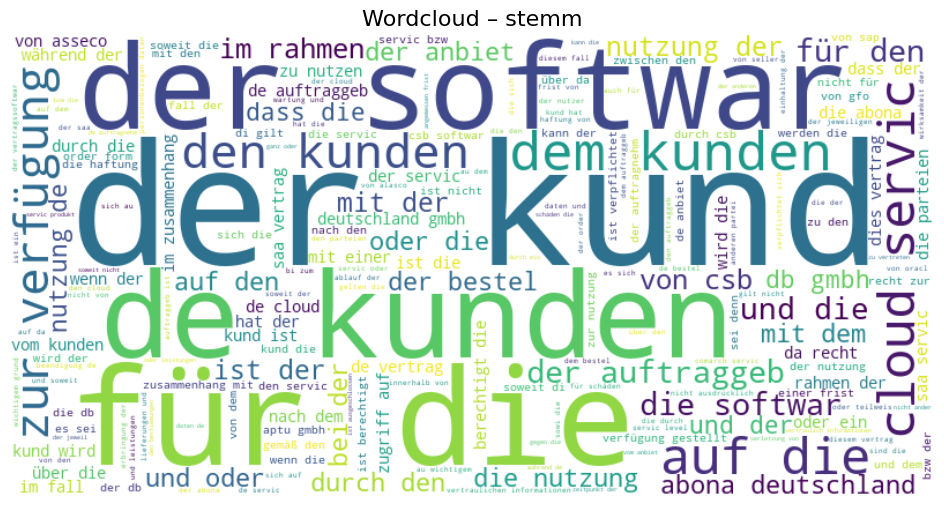

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
topic_text = " ".join(df_structured["paragraph_content_stemm"].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(topic_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(f"Wordcloud – stemm", fontsize=16)
plt.show()

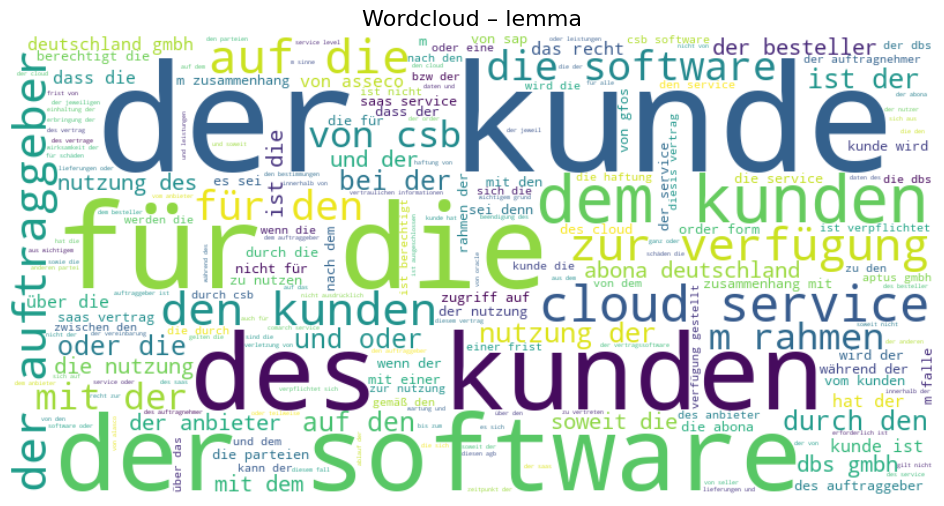

In [14]:
topic_text = " ".join(df_structured["paragraph_content_lemma"].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(topic_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(f"Wordcloud – lemma", fontsize=16)
plt.show()

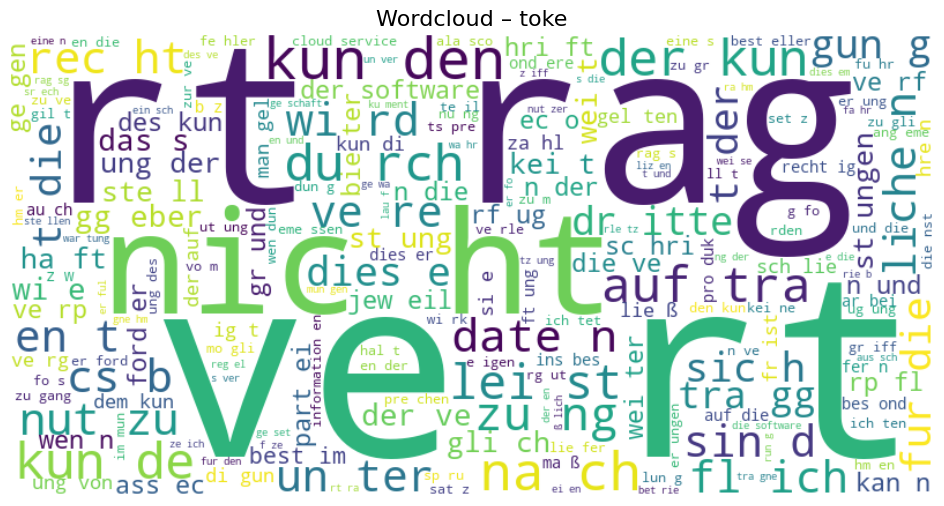

In [15]:
topic_text = " ".join(
    word for tokens in df_structured["paragraph_content_token"].dropna() for word in tokens
)

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(topic_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(f"Wordcloud – toke", fontsize=16)
plt.show()

In [16]:
file_path = '../data/data_clean.xlsx'
df_structured.to_excel(file_path, index=False)

file_path = '../data/data_clean.pkl'  
df_structured.to_pickle(file_path)


# STEP 2 clean catalogue

In [18]:
cat = pd.read_excel("../data/catalogue_raw.xlsx")
print(cat.head())
cat["example"] = cat["example"].str.strip('„“"').apply(clean_paragraph_text2)
cat["paragraph_topic"] = cat["paragraph_topic"].apply(
    lambda x: x.replace("&", 'und').strip().replace(" ","_")
)
print(cat.head())
file_path = '../data/catalogue_clean.xlsx'
cat.to_excel(file_path, index=False)

file_path = '../data/catalogue_clean.pkl'  
cat.to_pickle(file_path)


                       paragraph_topic  \
0  Projektkosten & Zahlungsmodalitäten   
1  Projektkosten & Zahlungsmodalitäten   
2  Projektkosten & Zahlungsmodalitäten   
3  Projektkosten & Zahlungsmodalitäten   
4  Projektkosten & Zahlungsmodalitäten   

                                       section_topic  \
0  Sind sämtliche Kostenarten und -bestandteile (...   
1  Ist das Vergütungsmodell eindeutig festgelegt ...   
2  Ist ein Zahlungsplan mit konkreten Fälligkeite...   
3  Sind Währung, Rechnungsstellung, Zahlungsfrist...   
4  Regelt der Vertrag den Umgang mit Nebenkosten ...   

                                             example  
0  „Im Festpreis von 200.000 € sind sämtliche Lei...  
1  „Der Kunde zahlt eine monatliche Pauschale von...  
2  „Die Vergütung ist in drei Raten zahlbar: 30% ...  
3  „Alle Preise verstehen sich in Euro zuzüglich ...  
4  „Reise- und Übernachtungskosten werden nur ers...  
                         paragraph_topic  \
0  Projektkosten_und_Zahlungsmodalit